PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
     PassengerId  Survived  Pclass  \
7              8         0       3   
11            12         1       1   
15            16         1       2   
16            17         0       3   
33            34         0       2   
..           ...       ...     ...   
827          828         1       2   
829          830         1       1   
831          832         1       2   
851          852         0       3   
879          880         1       1   

                                              Name     Sex    Age  SibSp  \
7                   Palsson, Master. Gosta Leonard    male   2.00      3   
11                        Bonnell, Miss. Elizabeth  female  58.00      0   
15                Hewlett, Mrs. (Mary D Kingcome)   female  55.00      0  

<ipython-input-1-817ec99b6e86>:15: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_data.fillna(train_data.median(), inplace=True)
<ipython-input-1-817ec99b6e86>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Sex'] = le.fit_transform(train_data['Sex'])
<ipython-input-1-817ec99b6e86>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Epoch 1/600


/usr/local/lib/python3.8/dist-packages/keras/backend.py:5676: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


19/19 [==============================] - 9s 49ms/step - loss: 24.4371 - accuracy: 0.5685 - val_loss: 1.2363 - val_accuracy: 0.5766
Epoch 2/600
19/19 [==============================] - 0s 11ms/step - loss: 14.1872 - accuracy: 0.5806 - val_loss: 0.7432 - val_accuracy: 0.5685
Epoch 3/600
19/19 [==============================] - 0s 11ms/step - loss: 10.2808 - accuracy: 0.5598 - val_loss: 0.6671 - val_accuracy: 0.5887
Epoch 4/600
19/19 [==============================] - 0s 13ms/step - loss: 8.6819 - accuracy: 0.5165 - val_loss: 0.6756 - val_accuracy: 0.5806
Epoch 5/600
19/19 [==============================] - 0s 10ms/step - loss: 6.4043 - accuracy: 0.5373 - val_loss: 0.6709 - val_accuracy: 0.6008
Epoch 6/600
19/19 [==============================] - 0s 11ms/step - loss: 4.7612 - accuracy: 0.5823 - val_loss: 0.6739 - val_accuracy: 0.5927
Epoch 7/600
19/19 [==============================] - 0s 11ms/step - loss: 3.9817 - accuracy: 0.5529 - val_loss: 0.6749 - val_accuracy: 0.5968
Epoch 8/600
19/

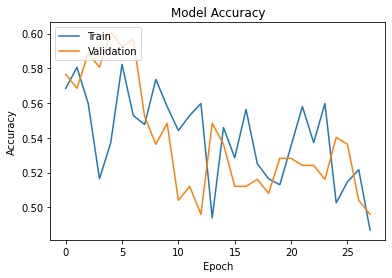

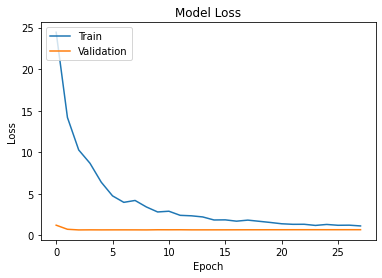

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load the dataset
train_data = pd.read_csv("https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv")

# Check for missing values
print(train_data.isnull().sum())

# Replace missing values with the median
train_data.fillna(train_data.median(), inplace=True)

# Check for outliers in the 'Age' column
q1 = train_data['Age'].quantile(0.25)
q3 = train_data['Age'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers = train_data[(train_data['Age'] < lower_bound) | (train_data['Age'] > upper_bound)]
print(outliers)

# Remove the outliers
train_data = train_data[(train_data['Age'] >= lower_bound) & (train_data['Age'] <= upper_bound)]

# Convert non-numeric features to numeric representations using label encoding
le = LabelEncoder()
train_data['Sex'] = le.fit_transform(train_data['Sex'])
train_data['Embarked'] = le.fit_transform(train_data['Embarked'])

# Perform one-hot encoding on the 'Pclass' column
train_data = pd.get_dummies(train_data, columns=['Pclass'])

# Remove the string columns from the data
train_data = train_data.drop(['Name', 'Ticket', 'Cabin'], axis=1)

# Split the data into training and validation sets
train_dataset, val_dataset = train_test_split(train_data, test_size=0.3)

# Split the data into input and target
train_target = train_dataset.pop("Survived").replace({'0': 0, '1': 1}).astype('float32')
val_target = val_dataset.pop("Survived").replace({'0': 0, '1': 1}).astype('float32')

# Prepare the data for training
train_dataset = tf.data.Dataset.from_tensor_slices((train_dataset.values, train_target.values))
train_dataset = train_dataset.shuffle(len(train_dataset)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((val_dataset.values, val_target.values))
val_dataset = val_dataset.batch(32)

# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="relu", input_shape=(10,)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


# Compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer="adam", metrics=["accuracy"])

# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

# Train the model
history = model.fit(train_dataset, epochs=600, validation_data=val_dataset, callbacks=[early_stopping])

# Plot the training history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

# Load the dataset
train_data = pd.read_csv("https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv")

# Check for missing values
print(train_data.isnull().sum())

# Replace missing values with the median
train_data.fillna(train_data.median(), inplace=True)

# Check for outliers in the 'Age' column
q1 = train_data['Age'].quantile(0.25)
q3 = train_data['Age'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers = train_data[(train_data['Age'] < lower_bound) | (train_data['Age'] > upper_bound)]
print(outliers)

# Remove the outliers
train_data = train_data[(train_data['Age'] >= lower_bound) & (train_data['Age'] <= upper_bound)]

# Drop non-numeric columns
train_data = train_data.drop(columns=['Name', 'Ticket', 'Cabin'])

# Convert non-numeric features to numeric representations using label encoding
le = LabelEncoder()
train_data['Sex'] = le.fit_transform(train_data['Sex'])
train_data['Embarked'] = le.fit_transform(train_data['Embarked'])

# Perform one-hot encoding on the 'Pclass' column
train_data = pd.get_dummies(train_data, columns=['Pclass'])

# Split the data into training and validation sets
train_dataset, val_dataset = train_test_split(train_data, test_size=0.2)

# Split the data into input and target
train_target = train_dataset.pop("Survived").replace({'0': 0, '1': 1}).astype('float32')
val_target = val_dataset.pop("Survived").replace({'0': 0, '1': 1}).astype('float32')

# Prepare the data for training
train_dataset = tf.data.Dataset.from_tensor_slices((train_dataset.values, train_target.values))
train_dataset = train_dataset.shuffle(len(train_dataset)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((val_dataset.values, val_target.values))
val_dataset = val_dataset.batch(32)

# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="relu", input_shape=(train_data.shape[1],)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation=None)
])

# Compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer="adam", metrics=["accuracy"])

# Set up callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1)

# Train the model
history = model.fit(train_dataset, epochs=100, validation_data=val_dataset, callbacks=[early_stopping, tensorboard])

# Plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
     PassengerId  Survived  Pclass  \
7              8         0       3   
11            12         1       1   
15            16         1       2   
16            17         0       3   
33            34         0       2   
..           ...       ...     ...   
827          828         1       2   
829          830         1       1   
831          832         1       2   
851          852         0       3   
879          880         1       1   

                                              Name     Sex    Age  SibSp  \
7                   Palsson, Master. Gosta Leonard    male   2.00      3   
11                        Bonnell, Miss. Elizabeth  female  58.00      0   
15                Hewlett, Mrs. (Mary D Kingcome)   female  55.00      0  

<ipython-input-3-232da2e3f06f>:16: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_data.fillna(train_data.median(), inplace=True)


ValueError: ignored